In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns

from iglm import IgLM
from safetensors.torch import load_file
from esm.models.esm3 import ESM3
from transformers import AutoModel
from esm.sdk.api import ESMProtein, GenerationConfig
from matplotlib import pyplot as plt
from nltk.metrics import edit_distance
from tqdm import tqdm
from antiberty import AntiBERTyRunner

ModuleNotFoundError: No module named 'torch'

In [2]:
base_model = ESM3.from_pretrained("esm3-open", device=torch.device("cuda:1"))
finetuned_model = ESM3.from_pretrained("esm3-open", device=torch.device("cuda:1"))

Fetching 22 files: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 58438.69it/s]
/home/av47/miniconda3/envs/esm/lib/python3.12/site-packages/esm/pretrained.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` f

In [4]:
def load_weights(path, model):
    state_dict = torch.load(path, map_location="cuda:1")
    new_dict = {}
    
    for k, v in state_dict.items():
        if k in model.state_dict():
            new_dict[k] = v
    model.load_state_dict(new_dict)

In [5]:
load_weights("weights/20241201-144617/checkpoint-46362/pytorch_model.bin", finetuned_model)

/tmp/ipykernel_3909169/2961478943.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location="cuda:1")


In [15]:
def generate_sequences(model, N, batch_size, num_steps, temperature):
    prompt = "EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYC__________WGQGTLVTVSS"
    protein = ESMProtein(sequence=prompt)
    protein_list = [ESMProtein(sequence=prompt)] * batch_size
    config_list = [GenerationConfig(track="sequence", num_steps=num_steps, temperature=temperature)] * batch_size
    generated_sequences = []
    for _ in range(N//batch_size):
        generated_seqs = model.batch_generate(protein_list, config_list)
        generated_sequences.extend([seq.sequence[96:106] for seq in generated_seqs])
    return generated_sequences

In [22]:
base_seqs = generate_sequences(base_model, 1000, 100, 8, 1.0)
finetuned_seqs = generate_sequences(finetuned_model, 1000, 100, 8, 1.0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.75it/s]
/home/av47/miniconda3/envs/esm/lib/python3.12/site-packages/esm/pretrained.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` f

In [30]:
iglm = IgLM()

parent_sequence = "EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCXXXXXXXXXXWGQGTLVTVSS"
chain_token = "[HEAVY]"
species_token = "[HUMAN]"
infill_range = (96, 106)
num_seqs = 1000

generated_seqs = iglm.infill(
    parent_sequence,
    chain_token,
    species_token,
    infill_range=infill_range,
    num_to_generate=num_seqs,
)

iglm_seqs = [seq[96:106] for seq in generated_seqs]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 26.15it/s]


In [31]:
with open("outputs/esm3_base_seqs.txt", "w") as f:
    for seq in base_seqs:
        f.write(f"{seq}\n")

with open("outputs/esm3_finetuned_seqs.txt", "w") as f:
    for seq in finetuned_seqs:
        f.write(f"{seq}\n")

with open("outputs/iglm_seqs.txt", "w") as f:
    for seq in iglm_seqs:
        f.write(f"{seq}\n")

In [24]:
df = pd.read_csv("data/all.csv")
positive_seqs = df[df['label'] == 1]['seq'].tolist()
negative_seqs = df[df['label'] == 0]['seq'].tolist()

In [25]:
base_positive_edit_distances = []
finetuned_positive_edit_distances = []

for gen_seq in tqdm(base_seqs):
    pos_distances = [edit_distance(gen_seq, pos_seq) for pos_seq in positive_seqs]
    base_positive_edit_distances.append(np.mean(pos_distances))
 
for gen_seq in tqdm(finetuned_seqs):
    pos_distances = [edit_distance(gen_seq, pos_seq) for pos_seq in positive_seqs]
    finetuned_positive_edit_distances.append(np.mean(pos_distances))

  0%|▍                                                                                                                                                               | 3/1000 [00:27<2:31:49,  9.14s/it]


KeyboardInterrupt: 

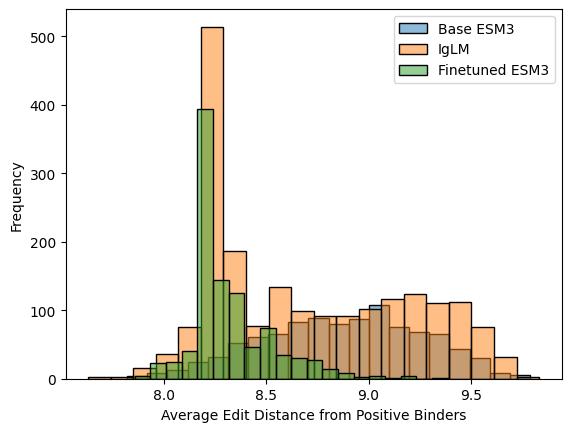

In [51]:
# sns.figure(figsize=(12, 6))

sns.histplot(np.load("outputs/base_seqs_edit_distance.npy"), bins=20, alpha=0.5, label="Base ESM3")
sns.histplot(np.load("outputs/iglm_seqs_edit_distance.npy"), bins=20, alpha=0.5, label="IgLM")
sns.histplot(np.load("outputs/finetuned_seqs_edit_distance.npy"), bins=20, alpha=0.5, label="Finetuned ESM3")

plt.xlabel("Average Edit Distance from Positive Binders")
plt.ylabel("Frequency")
plt.legend()
# sns.show()

In [44]:
base_negative_edit_distances = []
finetuned_negative_edit_distances = []

for gen_seq in tqdm(base_seqs):
    neg_distances = [edit_distance(gen_seq, neg_seq) for neg_seq in negative_seqs]
    base_negative_edit_distances.append(np.mean(neg_distances))
 
for gen_seq in tqdm(finetuned_seqs):
    neg_distances = [edit_distance(gen_seq, neg_seq) for neg_seq in negative_seqs]
    finetuned_negative_edit_distances.append(np.mean(neg_distances))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [25:42<00:00, 15.43s/it]


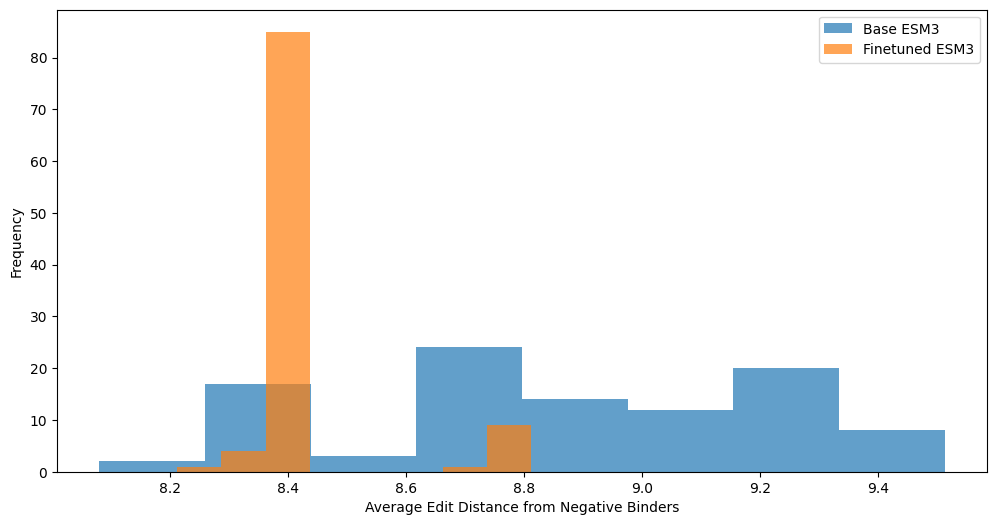

In [46]:
plt.figure(figsize=(12, 6))

plt.hist(base_negative_edit_distances, bins=8, alpha=0.7, label="Base ESM3")
plt.hist(finetuned_negative_edit_distances, bins=8, alpha=0.7, label="Finetuned ESM3")
plt.xlabel("Average Edit Distance from Negative Binders")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [24]:
antiberty = AntiBERTyRunner()

def get_log_likelihood(sequences):
    pll = antiberty.pseudo_log_likelihood(
        [f"EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYC{seq}WGQGTLVTVSS" for seq in sequences], 
        batch_size=16
    )
    # probabilities = torch.exp(pll)
    return pll

In [25]:
with open("outputs/esm3_base_seqs.txt", "r") as f:
    base_seqs = [line.strip() for line in f.readlines()]

with open("outputs/esm3_finetuned_seqs.txt", "r") as f:
    finetuned_seqs = [line.strip() for line in f.readlines()]

with open("outputs/iglm_seqs.txt", "r") as f:
    iglm_seqs = [line.strip() for line in f.readlines()]

base_pll = get_log_likelihood(base_seqs)
finetuned_pll = get_log_likelihood(finetuned_seqs)
iglm_pll = get_log_likelihood(iglm_seqs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:49<00:00,  5.91it/s]


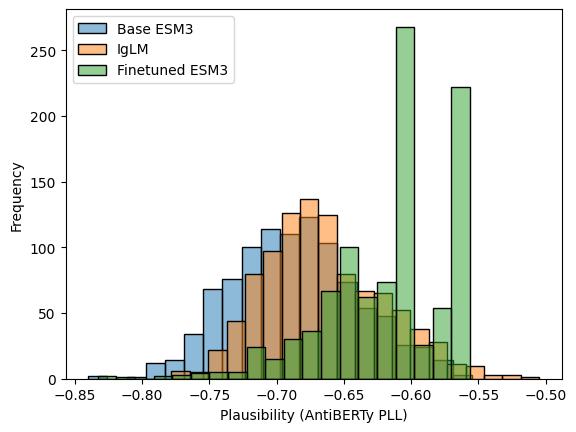

In [52]:
sns.histplot(base_pll.cpu(), bins=20, alpha=0.5, label="Base ESM3")
sns.histplot(iglm_pll.cpu(), bins=20, alpha=0.5, label="IgLM")
sns.histplot(finetuned_pll.cpu(), bins=20, alpha=0.5, label="Finetuned ESM3")
plt.xlabel("Plausibility (AntiBERTy PLL)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [41]:
k=400
_, base_indices = torch.topk(base_pll, k)
_, finetuned_indices = torch.topk(finetuned_pll, k)
_, iglm_indices = torch.topk(iglm_pll, k)

top_base_seqs = [base_seqs[i] for i in base_indices]
top_finetuned_seqs = [finetuned_seqs[i] for i in finetuned_indices]
top_iglm_seqs = [iglm_seqs[i] for i in iglm_indices]

In [49]:
seq_list = [f"EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYC{seq}WGQGTLVTVSS" for seq in list(set(top_finetuned_seqs))[:32]]

with open("outputs/top_finetuned.txt", "w") as f:
    for seq in seq_list:
        f.write(f"{seq}, {seq[96:106]}\n")